# Assignment 4 

Submitted By- Anjali Bhatnagar 2019201012

## Question 2 : Scene Recognition using Bag of Visual Words (BOVW)

Let us load the train data and then the testdata 

In [98]:
#importing the required packages 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.multiclass import OneVsRestClassifier
import random
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import os.path
from os import path
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

In [3]:
#storing the train path and the test path
train_p="/home/anjali/assignment-4-anjali9797/dataset/SUN_data/SUN_data/train/"
test_p="/home/anjali/assignment-4-anjali9797/dataset/SUN_data/SUN_data/test/"

Functions :

### 2.1 : Implementing Basic Bag of Words :)

In [4]:
def get_data(folder):
    data_x=list()#to store the data
    data_y=list()#to store the labels
    folders=os.listdir(folder)
    for label in folders:
        dir_name=folder+label+'/'
        if (path.isdir(dir_name) is True):
            imf=os.listdir(dir_name)
            for image in imf:
                img_path=dir_name+image
                img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                #standardise the image
                img = cv2.resize(img, (150,150))
                data_x.append(img)
                data_y.append(label)
    #currently the label contain the names for making training easy lets convert them to numbers
    labels_u=set(data_y)
    labels_u=list(labels_u)
    num_l=len(labels_u)
    num=0
    label_mapping = dict()
    for i in range(num_l):
        label_mapping[ labels_u[i]] = num
        num+=1
    return data_x,data_y,label_mapping
    

In [5]:
train_x,train_y,train_id=get_data(train_p)
test_x,test_y,test_id=get_data(test_p)

The images have been converted to gray scale and then stored and we have also resized it to 150 by 150 as mentioned in the question !

### 2.2 : BOW with Dense SIFT and normalizing the histograms

In [6]:
#function to get the descriptors
def get_descriptors(train_x,train_y ,sift_features ,step ,flag ):
    #calling sift 
    count=0
    des_list=list()
    des_images=list()
    y=list()
    num=len(train_x)
    sift=cv2.xfeatures2d.SIFT_create(sift_features)
    for i in range(num):
        img = train_x[i]
        len_y=img.shape[0]
        len_x=img.shape[1]
        #flag is true for dsift false for sift
        if flag is True:
            kps = [cv2.KeyPoint(x, y, step) for y in range(0, len_y, step) 
                                    for x in range(0, len_x, step)]
            sift = cv2.xfeatures2d.SIFT_create()
            kp , des = sift.compute(img,kps)
        else:
            kp , des = sift.detectAndCompute(img,None)
        #appending the descriptor we got from sift/dsift
        des_images.append(des)
        for j in des:
            des_list.append(j)
        y.append(train_y[i])
    return des_list ,des_images ,y

This functions gives us the descriptors now it depends on whether we are using normal sift or dense sift. Currently in the dense sift what we do is that we decide a certain amount of step size and on the basis of that we get the key points where as in normal sift we get the key points from the inbuilt sift and these are a fixed number comparatively very less as compared to the normal sift. So over here we have implemented the dense sift and sift part.

In [97]:
def get_histograms(descriptors , kmeans ,clusters ):
    histograms = list()
    for img_des in descriptors:
        temp_hist = np.zeros( clusters )
        no_des=len(img_des)
        for j in no_des:
            i=[img_des[j]]
            idx = kmeans.predict(i)
            temp_hist[ idx ] += 1
        histograms.append(temp_hist)
    histograms = np.array(histograms)
    histograms=histograms.astype('float64')
    return histograms

### BONUS PART :

In [142]:
def SPM_histograms( train_x , train_y,kmeans ,clusters ,step ,levels):
    hists = list()
    
    for img in train_x:
        hists.append(spm_feature(img , kmeans ,clusters , levels ,step ))
    hists = np.array(hists)
    hists=hists.astype('float64')
    
    return hists
        
    

In [154]:
def spm_feature(img , kmeans , clusters , levels ,step ):
    full_hist = list()
    w = img.shape[1]
    h = img.shape[0]
    for lev in range(levels + 1):
        div=2**lev
        w_start = 0
        w_stride = math.floor(w / div)
        h_start = 0
        h_stride = math.floor(h / div)
        for i in range(1 , div + 1):
            w_start = 0
            for j in range( 1 , div + 1):
                sub_img = img[ h_start : h_start+h_stride , w_start : w_start+w_stride ]
                #kp , des = Dsift(sub_img ,step)
                len_y=sub_img.shape[0]
                len_x=sub_img.shape[1]
                kps = [cv2.KeyPoint(x, y, step) for y in range(0, len_y, step) 
                                    for x in range(0, len_x, step)]
                sift = cv2.xfeatures2d.SIFT_create()
                kp , des = sift.compute(sub_img,kps)
                #sub histogram for these
                temp_hist = np.zeros( clusters )
                for i in des:
                    idx = kmeans.predict([i])
                    temp_hist[ idx ] += 1
                if lev==0:
                    lev_weight=1/4
                elif lev==1:
                    lev_weight=1/4
                else:
                    lev_weight=1/2
                temp_hist = lev_weight*temp_hist
                w_start += w_stride
                if len(full_hist)==0:
                    full_hist = temp_hist
                else:
                    full_hist = np.concatenate((full_hist, temp_hist), axis=None)
            h_start += math.floor(h / div)
    return full_hist

---------------------------------------------------------------------------------------------------------

Defining Functions to train and test !

In [115]:
#training BOW
#flag-> flag[0]-> 1 for dense sift 0 for sift . flag[1]-> 1 for hist_norm 0 for no norm
def BOW_train(train_x,train_y,label_mapping ,params, flag,bonus=False ):
    #variable parameters
    clusters=params["num_c"]
    step=params["num_step"]
    reg_para=params["r"]
    svm_iter=params["iter"]
    sift_features=params["sift_f"]
    #getting the descriptor
    des_list ,des_images , y = get_descriptors( train_x,train_y ,sift_features ,step, flag[0] )
    #converting to a np array of type float
    des_list = np.array(des_list )
    des_list=des_list.astype('float64')
    #kmeans
    kmeans = MiniBatchKMeans(n_clusters=clusters)
    kmeans.fit(des_list)
    if bonus is True:
        hists = SPM_histograms(train_x,train_y, kmeans ,clusters ,step ,2)
    else:
        hists = get_histograms(des_images , kmeans ,clusters)
    #scaling hists
    stds=StandardScaler().fit(hists)
    #if we are normalizing we transform
    if flag[1]:
        hists=stds.transform(hists)
    #classifying
    clf=OneVsRestClassifier(LinearSVC(C=reg_para,max_iter=svm_iter)).fit(hists,y)
    return kmeans , stds ,clf

In [116]:
#testing
def BOW_test(test_x,test_y,test_id ,params, kmeans ,scaling, svm_clf , flag,bonus=False):
    clusters=params["num_c"]
    step=params["num_step"]
    reg_para=params["r"]
    svm_iter=params["iter"]
    sift_features=params["sift_f"]
    des_list ,des_images , y = get_descriptors( test_x,test_y ,sift_features ,step , flag[0] )
    #histograms
    if bonus is True:
        hists = SPM_histograms(test_x,test_y, kmeans ,clusters ,step ,2)
    else:
        hists = get_histograms(des_images , kmeans ,clusters)
    if flag[1] == True:
        hists = scaling.transform(hists)
    #prediction
    pred = svm_clf.predict(hists)
    return pred

In [10]:
params=dict()
params["num_c"]=150#to store number of clusters
params["num_step"]=5#to store the number of steps
params["r"]=1# value of c in svm
params["iter"]=5000#to store the number of svm iterations
params["sift_f"]=200#number of sift features
flags=[True,True]

In [67]:

kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)

	 Accuracy : 0.49375


In [70]:
dsift_accuracy=accuracy_score(test_y,pred)

In [72]:
flags[0]=False#Not use dsift
kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)

In [73]:
sift_accuracy=accuracy_score(test_y,pred)

Comparing the Dense Sift with Sift in terms of accuracy 

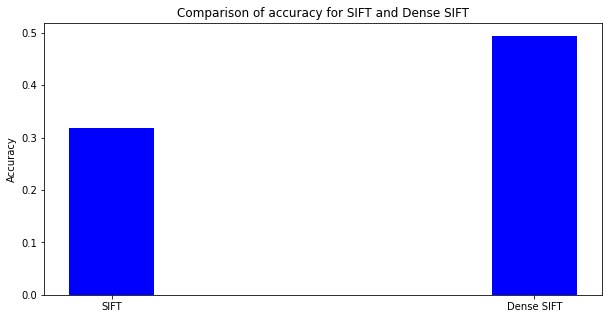

In [75]:
x = ['SIFT' ,'Dense SIFT']
fig = plt.figure(figsize = (10, 5)) 
prec=[sift_accuracy,dsift_accuracy]
plt.bar(x, prec, color ='blue', width = 0.2) 
plt.xlabel("") 
plt.ylabel("Accuracy") 
plt.title("Comparison of accuracy for SIFT and Dense SIFT") 
plt.show() 

Hence we can conclude that Dense SIFT is better than SIFT in terms of accuracy . Now we will try experimenting with various parameters to find the best parameter values and accordingly compare them !

In [86]:
flags[0]=True
clust = [50 ,100 ,150 ,200 ,250,500]
result=list()
for i in clust:
    params["num_c"]=i
    kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
    pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)
    #calculating the accuracy
    result.append(accuracy_score(test_y,pred)) 
    print("Iteration: ", i)

Iteration:  50
Iteration:  100
Iteration:  150
Iteration:  200
Iteration:  250
Iteration:  500


In [87]:
print(result)

[0.53125, 0.48125, 0.5375, 0.56875, 0.54375, 0.5375]


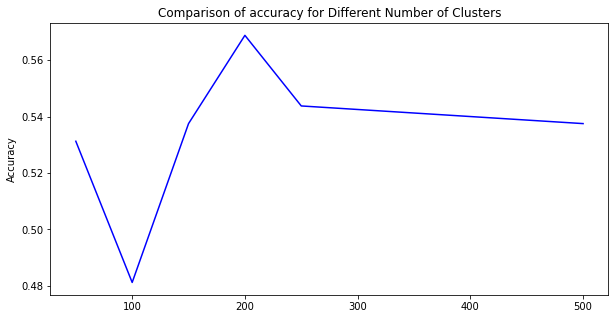

In [90]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(clust, result, color ='blue') 
plt.xlabel("") 
plt.ylabel("Accuracy") 
plt.title("Comparison of accuracy for Different Number of Clusters") 
plt.show()

From this graph we can conclude that the No of Clusters for which we get the best value is 200

### Comparison of accuracy and the Number of Iterations of SVM 

In [14]:
params["num_step"]=5
iters=[500,1000,2000,3000,5000]
result=list()
for i in iters:
    params["iter"]=i
    kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
    pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)
    #calculating the accuracy
    result.append(accuracy_score(test_y,pred)) 
    print("Iteration: ", i)


Iteration:  500
Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  5000


In [18]:
print(result)

[0.5375, 0.54375, 0.5375, 0.5443, 0.55625]


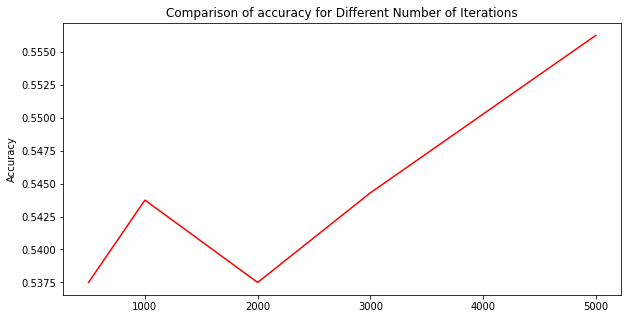

In [19]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(iters, result, color ='red') 
plt.xlabel("") 
plt.ylabel("Accuracy") 
plt.title("Comparison of accuracy for Different Number of Iterations") 
plt.show()

Nearly same though as we got best for number of iterations 5000 we fix it to that

### Comparison of accuracy for Number of SIFT Descriptors( Varying the Step Size for this purpose)

In [11]:
params["num_c"]=200
steps=[5,10,20,50,100]
result=list()
for i in steps:
    params["num_step"]=i
    kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
    pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)
    #calculating the accuracy
    result.append(accuracy_score(test_y,pred)) 
    print("Iteration: ", i)

Iteration:  5
Iteration:  10
Iteration:  20
Iteration:  50
Iteration:  100


In [12]:
print(result)

[0.53125, 0.4875, 0.51875, 0.375, 0.38125]


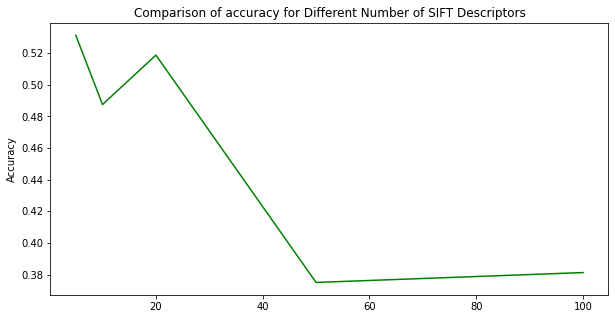

In [13]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(steps, result, color ='green') 
plt.xlabel("") 
plt.ylabel("Accuracy") 
plt.title("Comparison of accuracy for Different Number of SIFT Descriptors") 
plt.show()

Conclusion : Step Size-> 5 

### 2.3 : Tuning the Regularization Parameter Lambda

In [21]:
lamb=[0.01,0.1,0.2,0.5,1.0,2.0]
result=list()
for i in lamb:
    params["r"]=i
    kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
    pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)
    #calculating the accuracy
    result.append(accuracy_score(test_y,pred)) 
    print("Iteration: ", i)

Iteration:  0.01
Iteration:  0.1
Iteration:  0.2
Iteration:  0.5
Iteration:  1.0
Iteration:  2.0


In [23]:
print(result)

[0.65, 0.53125, 0.55, 0.54375, 0.55, 0.50625]


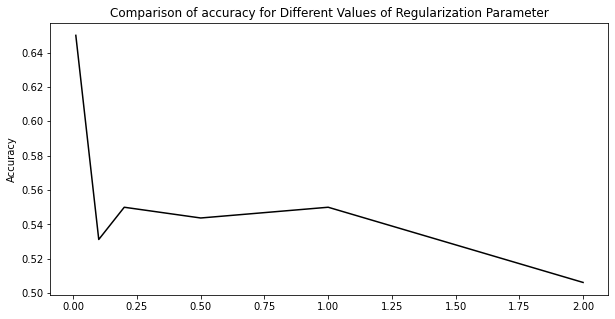

In [24]:
fig = plt.figure(figsize = (10, 5)) 
plt.plot(lamb, result, color ='black') 
plt.xlabel("") 
plt.ylabel("Accuracy") 
plt.title("Comparison of accuracy for Different Values of Regularization Parameter") 
plt.show()

Conclusion: Best Value of C : 0.01

In [25]:
params["r"]=0.01

### Final Accuracy Obtained : 0.65

### 2.4: PLotting Confusion Matrix with and without Normalization to estimate the Performance of the Model

#### -->With Normalized Histogram :

In [26]:
flags[1]=True#true for normalizing histograms
kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)
#calculating the accuracy
result.append(accuracy_score(test_y,pred)) 

Accuracy: 0.65


<AxesSubplot:>

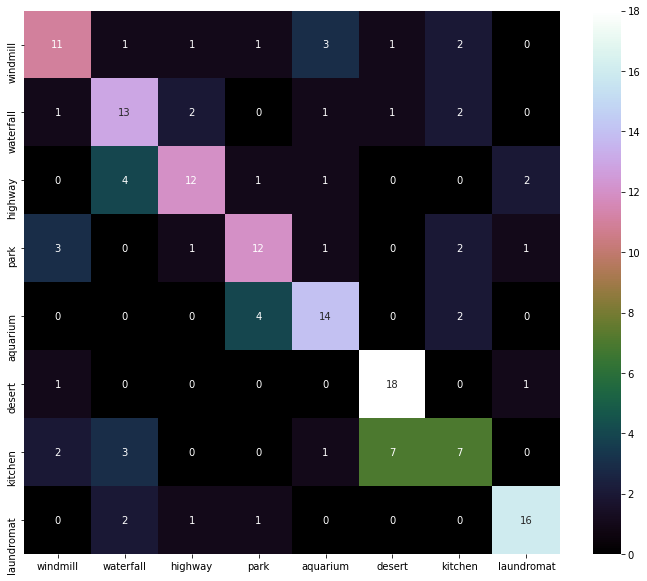

In [33]:
#printing the accuracy
ans=accuracy_score(test_y,pred)
conf=confusion_matrix(test_y,pred)
df = pd.DataFrame(conf, index = train_id,columns = train_id)
plt.figure(figsize = (12,10))
print("Accuracy:",ans)
sn.heatmap(df, annot=True,cmap="cubehelix")

#### --> Without Normalized Histogram :

Accuracy: 0.55


<AxesSubplot:>

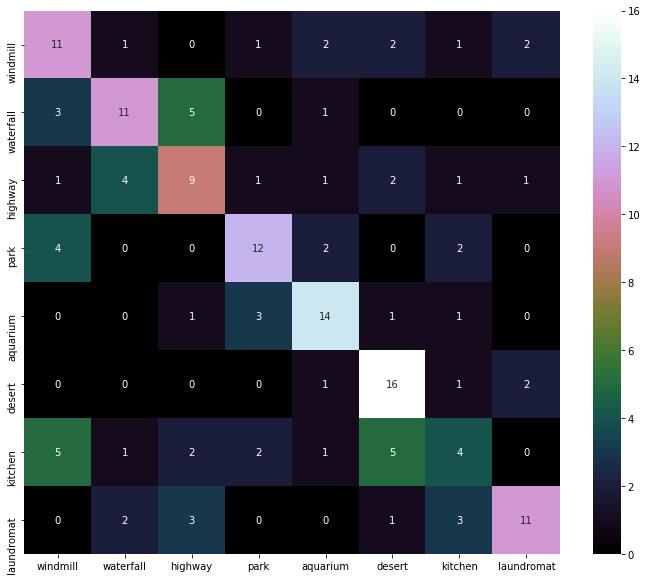

In [34]:
flags[1]=False#false for not normalizing histograms
kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)
#calculating the accuracy
ans2=accuracy_score(test_y,pred)
conf2=confusion_matrix(test_y,pred)
df = pd.DataFrame(conf2, index = train_id,columns = train_id)
plt.figure(figsize = (12,10))
print("Accuracy:",ans2)
sn.heatmap(df, annot=True,cmap="cubehelix")

Comparing the Accuracy we get while using Normalized Histogram and Histogram without Normalizing

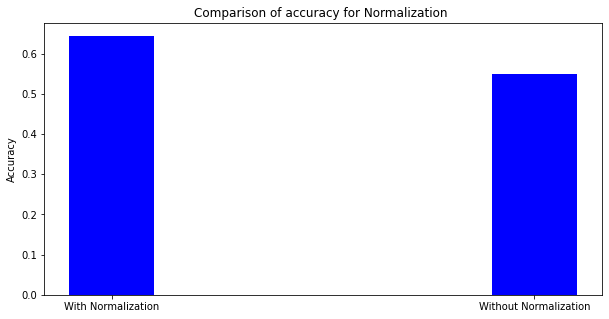

In [35]:
x = ['With Normalization' ,'Without Normalization']
fig = plt.figure(figsize = (10, 5)) 
prec=[ans,ans2]
plt.bar(x, prec, color ='blue', width = 0.2) 
plt.xlabel("") 
plt.ylabel("Accuracy") 
plt.title("Comparison of accuracy for Normalization ") 
plt.show() 

Now let us visualise some images which are classified correct and incorrect !

In [36]:
flags[1]=True
kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags)
pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags)

In [96]:
#for i in range(len(test_y)):
    #print(test_y[i],pred[i])

In [65]:
def correct_incorrect(name,test_y,pred):
    correct=list()
    incorrect=list()
    for i in range(len(test_y)):
        if test_y[i]!=name:
            continue
        if test_y[i]==pred[i]:
            #print(pred[i],test_y[i])
            correct.append(i)
        else:
            incorrect.append(i)
    return correct,incorrect

<AxesSubplot:title={'center':'Confusion Matrix'}>

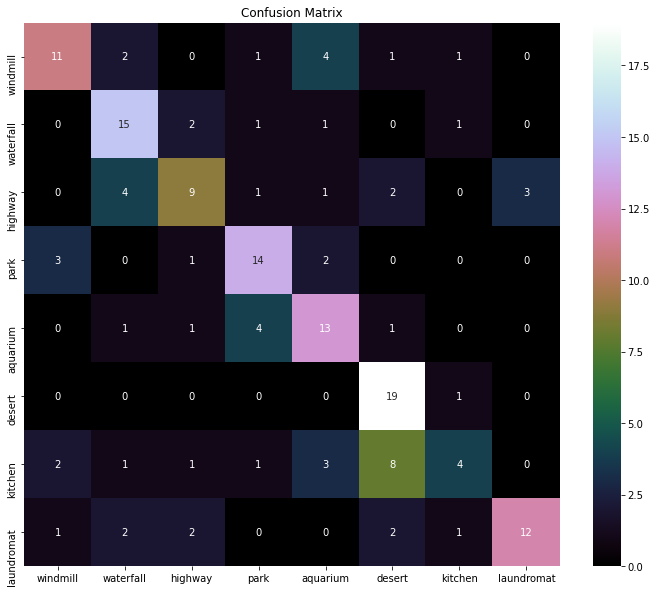

In [100]:
plt.figure(figsize = (12,10))
conf=confusion_matrix(test_y,pred)
df = pd.DataFrame(conf, index = train_id,columns = train_id)
plt.title("Confusion Matrix")
sn.heatmap(df, annot=True,cmap="cubehelix")

#### Displaying the correct images for Park :

In [75]:
correct,incorrect=correct_incorrect("park",test_y,pred)

Images for Park Classified Correctly


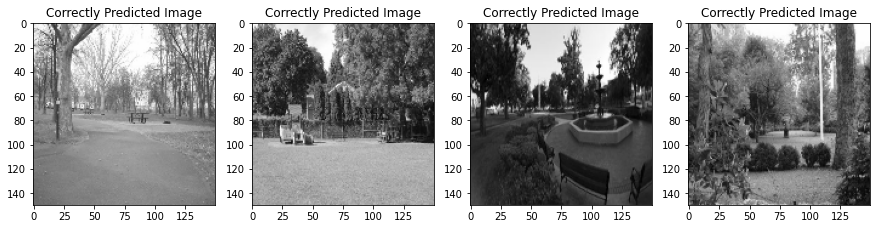

In [76]:
print("Images for Park Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

In [72]:
correct,incorrect=correct_incorrect("waterfall",test_y,pred)

Images for Waterfall Classified Correctly


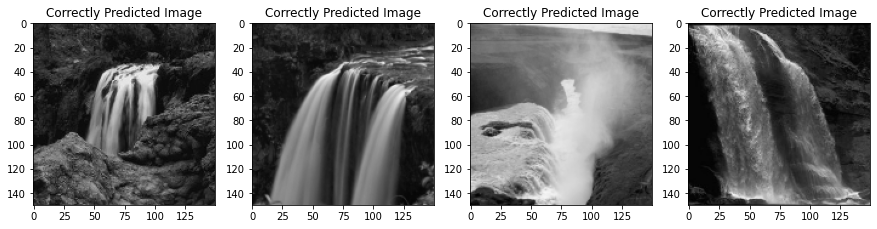

In [71]:

print("Images for Waterfall Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

In [77]:
correct,incorrect=correct_incorrect("kitchen",test_y,pred)

Images for Kitchen Classified Correctly


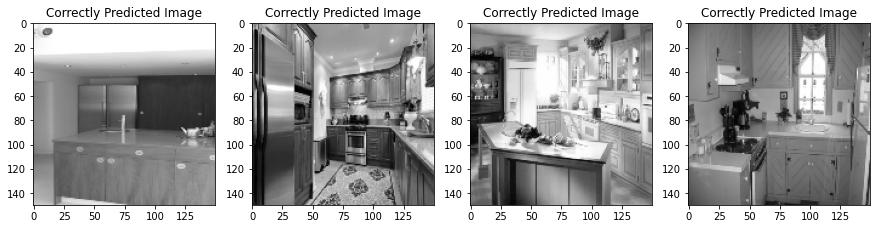

In [79]:
print("Images for Kitchen Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

Images for Aquarium Classified Correctly


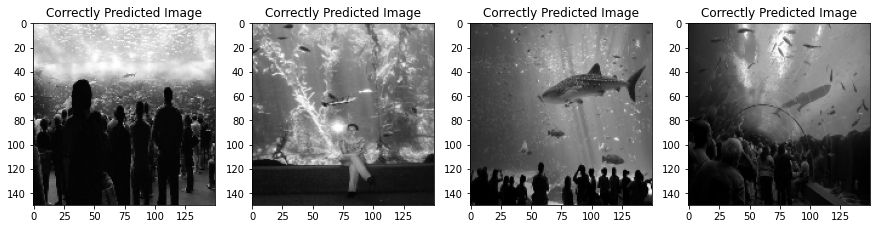

In [80]:
correct,incorrect=correct_incorrect("aquarium",test_y,pred)
print("Images for Aquarium Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

Images for Windmill Classified Correctly


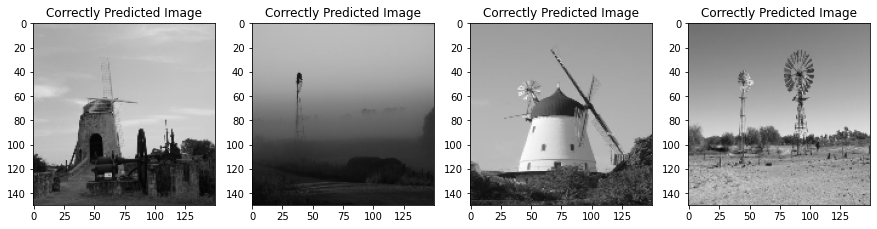

In [81]:
correct,incorrect=correct_incorrect("windmill",test_y,pred)
print("Images for Windmill Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

Images for Desert Classified Correctly


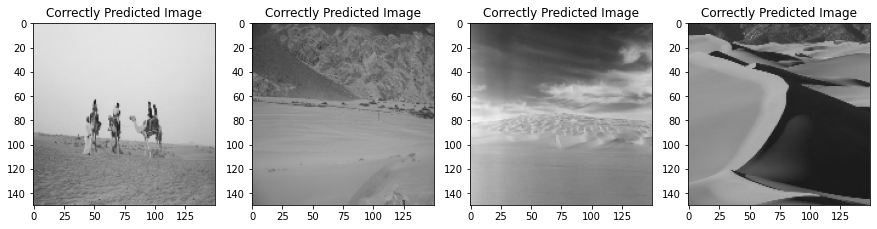

In [82]:
correct,incorrect=correct_incorrect("desert",test_y,pred)
print("Images for Desert Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

Images for Highway Classified Correctly


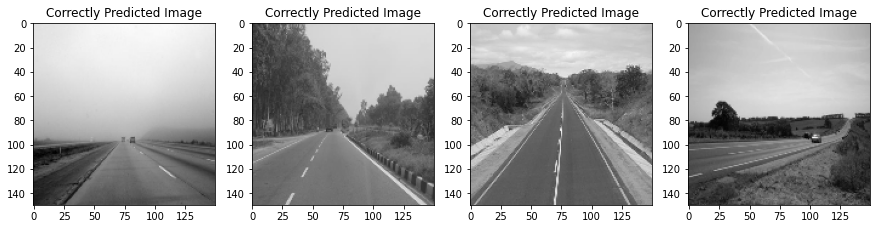

In [83]:
correct,incorrect=correct_incorrect("highway",test_y,pred)
print("Images for Highway Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

Images for Laundromat Classified Correctly


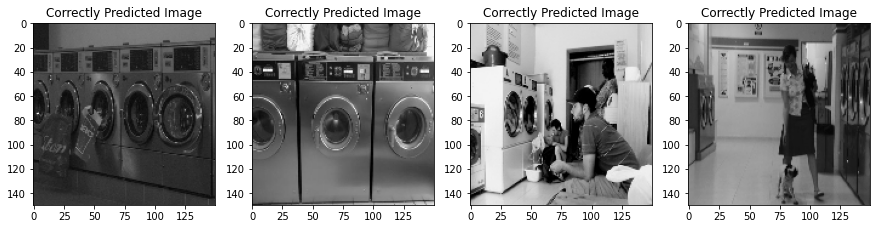

In [84]:
correct,incorrect=correct_incorrect("laundromat",test_y,pred)
print("Images for Laundromat Classified Correctly")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[correct[0]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[correct[1]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[correct[2]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[correct[3]],cv2.COLOR_BGR2RGB))
plt.title("Correctly Predicted Image")
plt.show()

Now let us look at some images which are incorrectly classified 

Images of laundromat classified incorrectly!


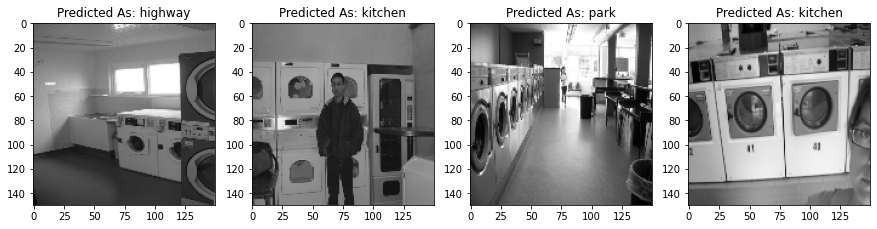

In [89]:
print("Images of laundromat classified incorrectly!")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[incorrect[0]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[0]])
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[incorrect[1]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[1]])
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[incorrect[2]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[2]])
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[incorrect[4]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[4]])
plt.show()

Images of Desert classified incorrectly!


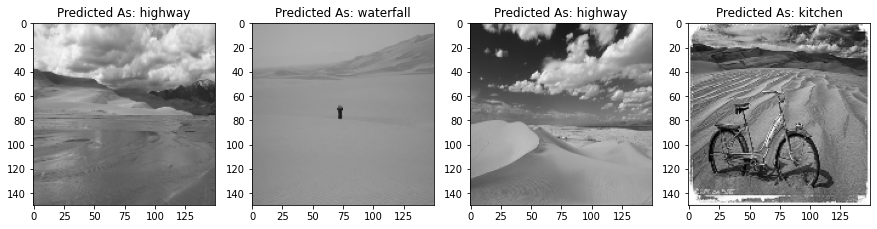

In [91]:
correct,incorrect=correct_incorrect("desert",test_y,pred)
print("Images of Desert classified incorrectly!")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[incorrect[0]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[0]])
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[incorrect[3]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[3]])
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[incorrect[2]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[2]])
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[incorrect[4]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[4]])
plt.show()

Images of Kitchen classified incorrectly!


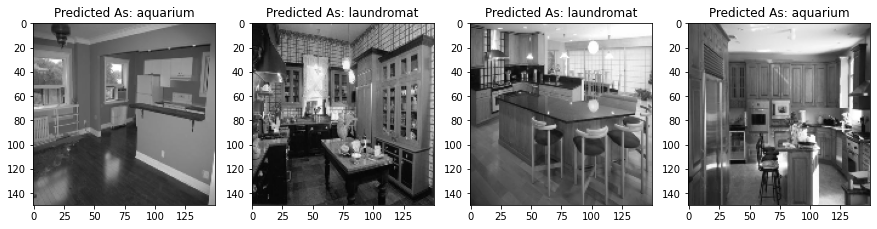

In [93]:
correct,incorrect=correct_incorrect("kitchen",test_y,pred)
print("Images of Kitchen classified incorrectly!")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[incorrect[0]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[0]])
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[incorrect[3]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[3]])
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[incorrect[1]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[1]])
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[incorrect[4]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[4]])
plt.show()

Images of Windmill classified incorrectly!


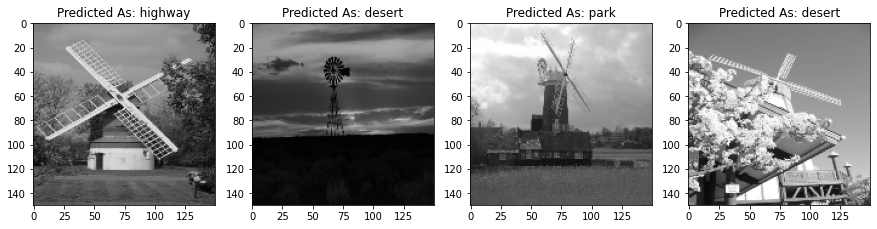

In [95]:
correct,incorrect=correct_incorrect("windmill",test_y,pred)
print("Images of Windmill classified incorrectly!")
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(test_x[incorrect[0]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[0]])
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(test_x[incorrect[3]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[3]])
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(test_x[incorrect[1]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[1]])
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(test_x[incorrect[4]],cv2.COLOR_BGR2RGB))
plt.title("Predicted As: "+pred[incorrect[4]])
plt.show()

Thus we finish with the Basics of Question 2 ---------------------------------------------------------------------

### BONUS : 2.5 : Implementing BOVW with Spatial Pyramid Matching

In the bonus part 5 we have to implement the  BOVW with spatial pyramid matching (maximum 3
levels, L = 2) to retain spatial information by dividing the image into a small
number of cells, and concatenating the histogram of each of these cells with a
suitable weight to the histogram of the original image.

In [151]:
kmeans , scale_transform , svm_clf = BOW_train(train_x,train_y,train_id ,params,flags,True)
pred=BOW_test(test_x,test_y,test_id ,params, kmeans ,scale_transform, svm_clf  , flags,True)
#calculating the accuracy

In [152]:
print(accuracy_score(test_y,pred))

0.65625


Displaying the Confusion Matrix:

<AxesSubplot:title={'center':'Confusion Matrix'}>

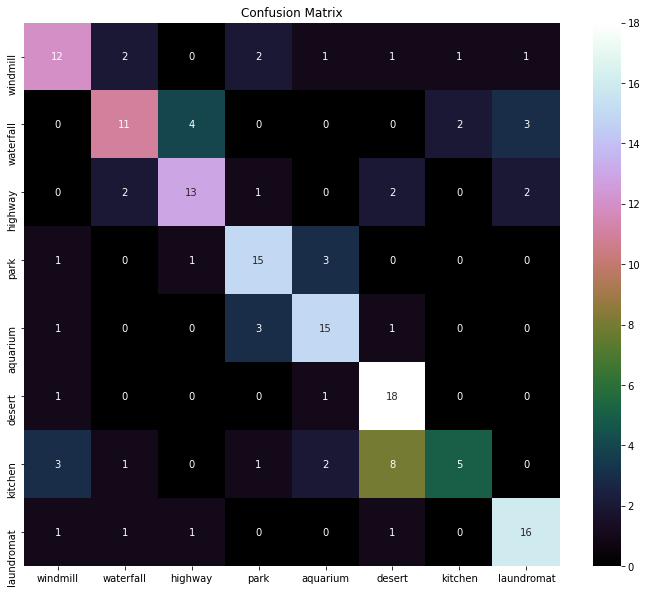

In [153]:
plt.figure(figsize = (12,10))
conf=confusion_matrix(test_y,pred)
df = pd.DataFrame(conf, index = train_id,columns = train_id)
plt.title("Confusion Matrix")
sn.heatmap(df, annot=True,cmap="cubehelix")

# --------------------------------------------------------------------------------------------------------------